# Misclassified images

In [2]:
from models import ClassificationModel

In [3]:
from datasets import Hotdog_NotHotdog
from networks import ResNet18Binary
from torch.utils.data import DataLoader
import torch

In [4]:
network = ResNet18Binary()
model = ClassificationModel.load_from_checkpoint("lightning_logs/epoch=41-step=1302.ckpt", network=network)

c:\Users\gusta\miniconda3\envs\bachelor\Lib\site-packages\pytorch_lightning\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.5.5, which is newer than your current Lightning version: v2.4.0


In [5]:
dataset = Hotdog_NotHotdog(train=False, image_size=128)
dataloader = DataLoader(dataset, batch_size=1862, shuffle=True)
model.eval()
batch = next(iter(dataloader))
with torch.no_grad():
    images, labels = batch['input'], batch['target']
    outputs = model.classify(images)



In [6]:
print(f"outputs: {outputs.flatten()}, \n labels: {labels}")

outputs: tensor([0, 1, 0,  ..., 0, 1, 0]), 
 labels: tensor([0, 1, 0,  ..., 0, 1, 0])


# Investigation of which images were misclassified by the model on the test set.


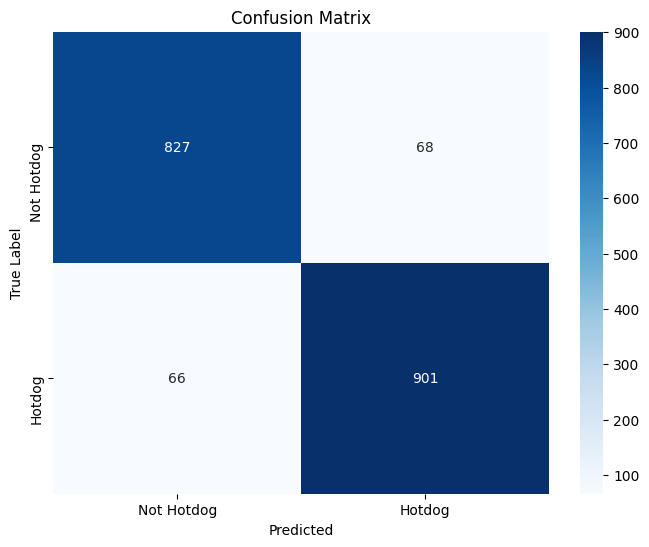

C:\Users\gusta\AppData\Local\Temp\ipykernel_12944\4203069854.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 8, i+1)


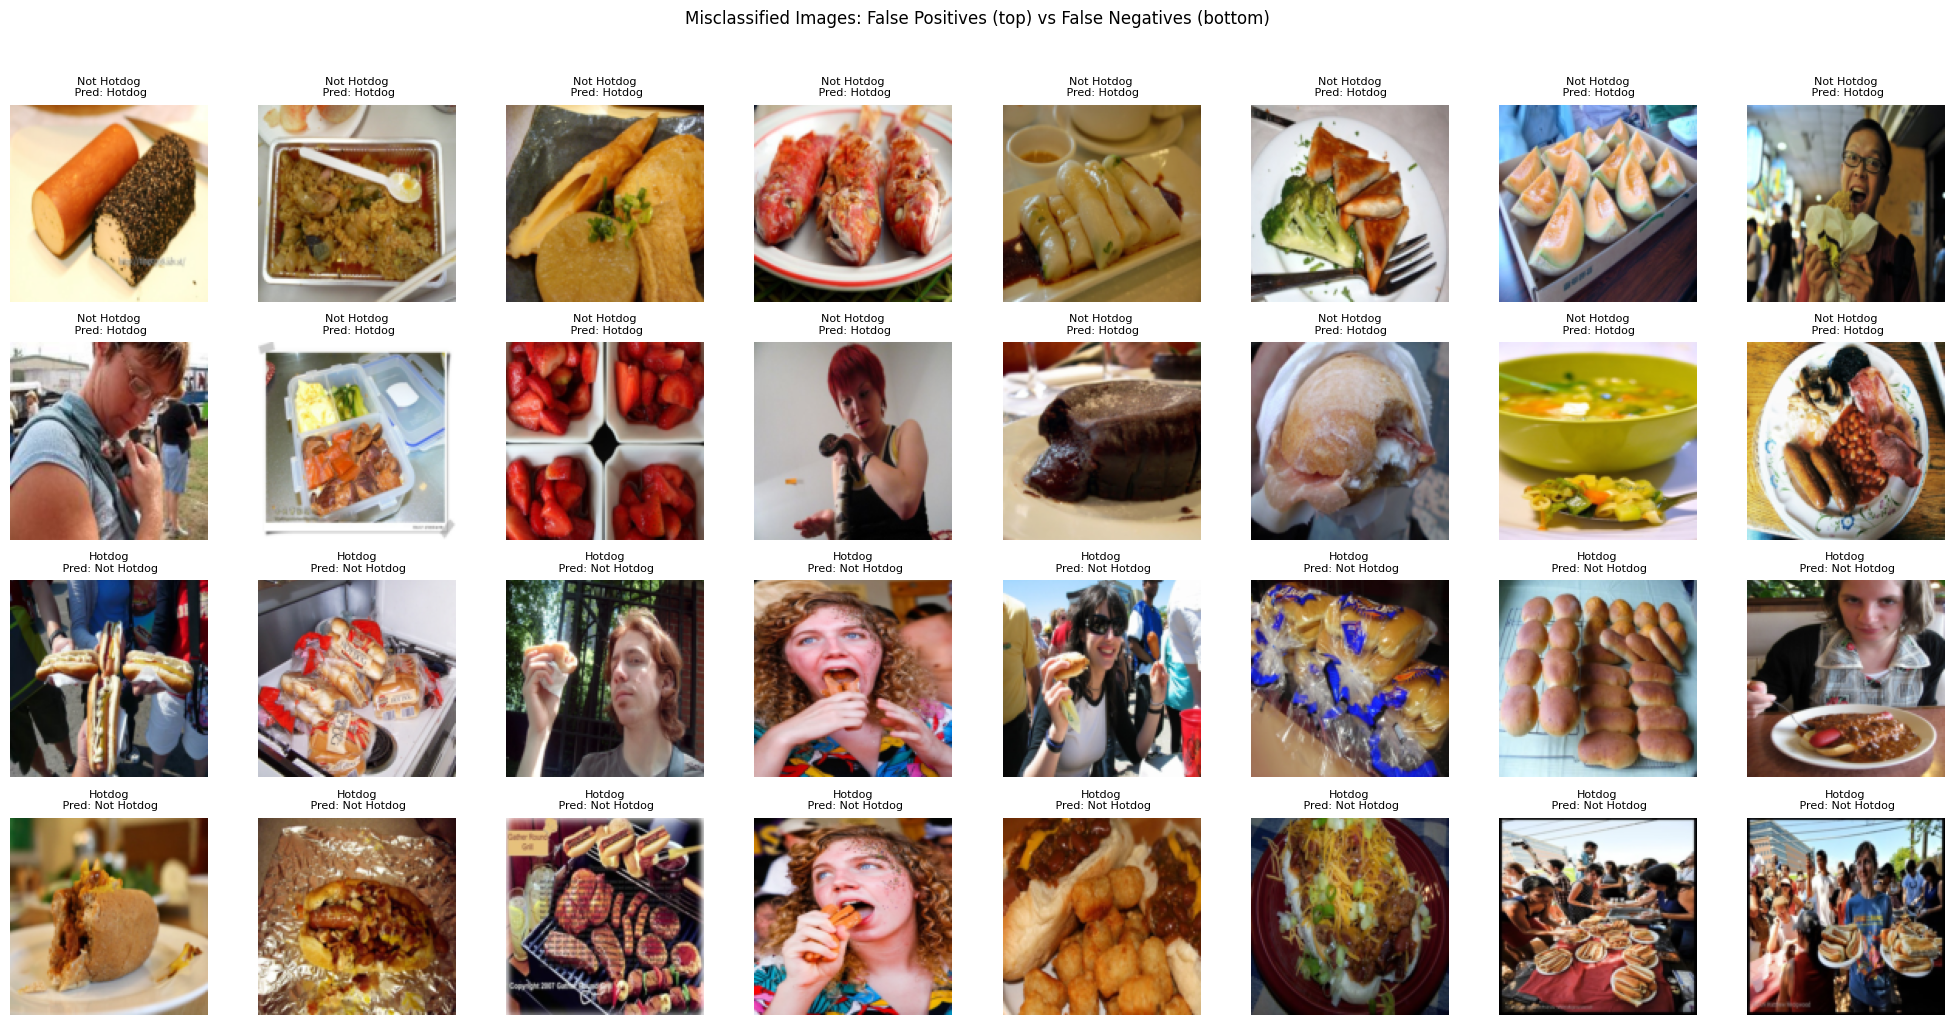

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
preds = (outputs.flatten() > 0.5).int()
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hotdog', 'Hotdog'], yticklabels=['Not Hotdog', 'Hotdog'])
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Identify misclassified images
misclassified_indices = (preds != labels).nonzero(as_tuple=True)[0]
misclassified_images = images[misclassified_indices]

# Separate false positives and false negatives
false_negatives = misclassified_indices[torch.logical_and(preds[misclassified_indices] == 1, labels[misclassified_indices] == 0)]
false_positives = misclassified_indices[torch.logical_and(preds[misclassified_indices] == 0, labels[misclassified_indices] == 1)]

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot false positives
num_fp = min(16, len(false_positives))
for i in range(num_fp):
    plt.subplot(4, 8, i+1)
    img = images[false_positives[i]].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img)
    plt.axis('off')
    plt.title('Not Hotdog\n Pred: Hotdog', fontsize=8)

# Plot false negatives
num_fn = min(16, len(false_negatives))
for i in range(num_fn):
    plt.subplot(4, 8, i+16+1)
    img = images[false_negatives[i]].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img)
    plt.axis('off')
    plt.title('Hotdog\n Pred: Not Hotdog', fontsize=8)

plt.suptitle('Misclassified Images: False Positives (top) vs False Negatives (bottom)', y=1.02)
plt.tight_layout()
plt.show()


# Further statistical analysis


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)    
f1 = f1_score(labels, preds)
roc_auc = roc_auc_score(labels, outputs.flatten().cpu())
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")





Precision: 0.9298, Recall: 0.9317, F1-score: 0.9308, ROC-AUC: 0.9279
